In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from HACluster import Clusterer
import networkx as nx
import datetime
%matplotlib inline

In [2]:
INPUT_FOLDER = 'geolife-trajectories/processed_data/'
FILE_NAME = INPUT_FOLDER + 'BeijingWalkingAreas.csv'

if not os.path.exists(FILE_NAME):
    list_df = []
    for file in os.listdir(INPUT_FOLDER):
        df = pd.read_csv(INPUT_FOLDER + file)
        list_df.append(df)
    df = pd.concat(list_df, ignore_index=True)
    df.drop('Unnamed: 0', inplace=True, axis=1)
    df['datetime'] = pd.to_datetime(df['datetime'], errors='ignore')
    # Beijing
    latMinB = 39.64
    latMaxB = 40.51
    longMinB = 115.76
    longMaxB = 116.88
    df = df[(df.lat.between(latMinB, latMaxB)) & (df.long.between(longMinB, longMaxB))]
    df = df[df['labels'] == 'walk']
    df = df[['lat', 'long', 'datetime', 'trajectory_id']]
    df.reset_index(drop=True, inplace=True)
    df.to_csv(FILE_NAME, index=False)

df = pd.read_csv(FILE_NAME)
if 'datetime' in df.columns:
    df['datetime'] = pd.to_datetime(df['datetime'])

# drop short trajectories
traj_len = 10
long_traj = df['trajectory_id'].value_counts()
long_traj = long_traj.where(long_traj.values > traj_len).dropna().keys()
df = df.loc[df['trajectory_id'].isin(long_traj)]
df.head()

,lat,long,datetime,trajectory_id
0,39.900008,116.412534,2008-06-17 10:53:07,20080617094444
1,39.900011,116.412560,2008-06-17 10:53:08,20080617094444
2,39.900015,116.412581,2008-06-17 10:53:09,20080617094444
3,39.900021,116.412616,2008-06-17 10:53:11,20080617094444
4,39.900030,116.412639,2008-06-17 10:53:12,20080617094444


2009-08-07 15:49:03 2008-11-05 11:33:07 2007-04-14 00:56:28 2011-12-31 15:18:07


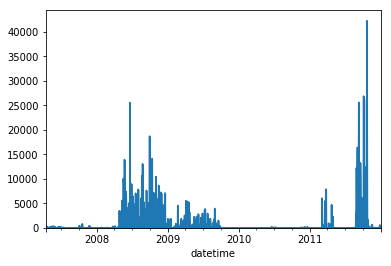

In [7]:
# get some datetime statistics: avg, med, min, max
def func_datetime(series, func=np.average):
    dt_min = series.min()
    deltas = [(x-dt_min).total_seconds() for x in series]
    return dt_min + np.timedelta64(int(func(deltas)), 's')

print(func_datetime(df['datetime']), func_datetime(df['datetime'], func=np.median), df['datetime'].min(), df['datetime'].max())
df.set_index('datetime').resample('D').count().lat.plot(kind='area')

In [3]:
# compress data to have unit time intervals
# for now I've decided to use one minute interval
one_minute_interval = datetime.timedelta(minutes=1)

def compress(df, verbose=False):
    list_df = []
    iter_count = 0
    if verbose:
        print('Amount of iterations needed: ' + str(len(df['trajectory_id'].unique())))
    for t_id in df['trajectory_id'].unique():
        iter_count += 1
        single_trajectory = df.loc[df['trajectory_id']==t_id]
        single_trajectory['datetime'] = pd.to_datetime(single_trajectory['datetime'].values.astype('<M8[m]'))
        list_single_df = []
        for st_dt in single_trajectory['datetime'].unique():
            avg_values = single_trajectory[['lat', 'long']].loc[single_trajectory['datetime'].values==st_dt].mean().values.tolist() + [st_dt, t_id]
            list_single_df.append(pd.DataFrame(np.reshape(avg_values, (1, len(avg_values))), columns=df.columns.values))
        list_df.append(pd.concat(list_single_df, ignore_index=True))
        if verbose:
            print('Iteration ' + str(iter_count) + ': Added ' + str(list_df[-1].count()[0]) + ' rows\n')
    return pd.concat(list_df, ignore_index=True)

df_compressed = compress(df)
df_compressed['datetime'] = pd.DatetimeIndex(df_compressed['datetime'].values)
df_compressed.head()

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,lat,long,datetime,trajectory_id
0,39.9001,116.413,2008-06-17 10:53:00,20080617094444
1,39.9001,116.414,2008-06-17 10:54:00,20080617094444
2,39.9001,116.415,2008-06-17 10:55:00,20080617094444
3,39.9002,116.417,2008-06-17 10:56:00,20080617094444
4,39.9004,116.418,2008-06-17 10:57:00,20080617094444


In [9]:
# the database isn't ideal for snapshot creating
len(df_compressed['datetime'].unique()) / len(df_compressed)

0.9123468426013195

In [4]:
# let's treat datetime column as only the time, i.e. as if all trajectories are recorded in the same day
df_compressed['datetime'] = pd.Series([datetime.datetime.combine(datetime.date.min, val.time()) for val in df_compressed['datetime']])
time_interval = df_compressed['datetime'].max() - df_compressed['datetime'].min()

df_compressed.head()

,lat,long,datetime,trajectory_id
0,39.9001,116.413,0001-01-01 10:53:00,20080617094444
1,39.9001,116.414,0001-01-01 10:54:00,20080617094444
2,39.9001,116.415,0001-01-01 10:55:00,20080617094444
3,39.9002,116.417,0001-01-01 10:56:00,20080617094444
4,39.9004,116.418,0001-01-01 10:57:00,20080617094444


In [11]:
# perform clusterization for every unique timestamp
def get_timestamps(df, verbose=False):
    ts = {}
    db = DBSCAN(eps=0.001, min_samples=2)
    for s_dt in sorted(df['datetime'].unique()):
        time_set = df[['lat', 'long', 'trajectory_id']].loc[df['datetime']==s_dt]
        db.fit(time_set[['lat', 'long']])
        n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
        if n_clusters_ > 0:
            time_set['cluster'] = pd.Series(db.labels_, index=time_set.index)
            time_set = time_set.loc[time_set['cluster']>=0]
            time_set.reset_index(drop=True, inplace=True)
            ts[s_dt] = time_set[['trajectory_id', 'cluster']]
        if verbose:
            print('Time: ' + str(s_dt) + '\nEstimated number of clusters: %d\n' % n_clusters_)
    return ts

timestamp_df = get_timestamps(df_compressed)

In [12]:
[i for i in timestamp_df.keys()]

[datetime.datetime(1, 1, 1, 0, 0),
 datetime.datetime(1, 1, 1, 0, 1),
 datetime.datetime(1, 1, 1, 0, 2),
 datetime.datetime(1, 1, 1, 0, 3),
 datetime.datetime(1, 1, 1, 0, 4),
 datetime.datetime(1, 1, 1, 0, 5),
 datetime.datetime(1, 1, 1, 0, 6),
 datetime.datetime(1, 1, 1, 0, 7),
 datetime.datetime(1, 1, 1, 0, 8),
 datetime.datetime(1, 1, 1, 0, 9),
 datetime.datetime(1, 1, 1, 0, 10),
 datetime.datetime(1, 1, 1, 0, 11),
 datetime.datetime(1, 1, 1, 0, 12),
 datetime.datetime(1, 1, 1, 0, 13),
 datetime.datetime(1, 1, 1, 0, 14),
 datetime.datetime(1, 1, 1, 0, 15),
 datetime.datetime(1, 1, 1, 0, 16),
 datetime.datetime(1, 1, 1, 0, 17),
 datetime.datetime(1, 1, 1, 0, 18),
 datetime.datetime(1, 1, 1, 0, 19),
 datetime.datetime(1, 1, 1, 0, 20),
 datetime.datetime(1, 1, 1, 0, 21),
 datetime.datetime(1, 1, 1, 0, 22),
 datetime.datetime(1, 1, 1, 0, 23),
 datetime.datetime(1, 1, 1, 0, 24),
 datetime.datetime(1, 1, 1, 0, 25),
 datetime.datetime(1, 1, 1, 0, 26),
 datetime.datetime(1, 1, 1, 0, 27),
 d

In [13]:
timestamp_df[df_compressed['datetime'].unique()[0]]

,trajectory_id,cluster
0,20080702094938,0
1,20080709020456,0
2,20080723082932,0
3,20080726083906,0
4,20080730092039,0
5,20080912103643,1
6,20081017103405,1
7,20081213104202,1
8,20090310104835,2
9,20080916093612,3


In [14]:
# get multigraph from timestamps
def get_graphs(dfs):
    
    def add_edges_from_cluster(G, values, timestamp):
        for i in range(len(values)):
            for j in range(i+1, len(values)):
                G.add_edge(values[i], values[j], weight=timestamp)
    
    G = nx.MultiGraph()
    for df_key in dfs.keys():
        df = dfs[df_key]
        for cl in df['cluster'].unique():
            add_edges_from_cluster(G, df['trajectory_id'].loc[df['cluster']==cl].values, df_key)
    return G

mgh = get_graphs(timestamp_df)

In [15]:
mgh.edges(data=True)[:5]

[(20081208233606,
  20081211234130,
  {'weight': datetime.datetime(1, 1, 1, 0, 0)}),
 (20081208233606,
  20081211234130,
  {'weight': datetime.datetime(1, 1, 1, 23, 57)}),
 (20081208233606,
  20081211234130,
  {'weight': datetime.datetime(1, 1, 1, 23, 58)}),
 (20081208233606,
  20081211234130,
  {'weight': datetime.datetime(1, 1, 1, 23, 59)}),
 (20081208233606,
  20081218233104,
  {'weight': datetime.datetime(1, 1, 1, 0, 0)})]

In [16]:
# merge multigraph to graph
def merge_multigraph_to_graph(M):
    G = nx.Graph()
    for u, v, data in M.edges_iter(data=True):
        if 'weight' in data:
            w = data['weight']
        else:
             raise ValueError('Invalid multigraph: one of the edges has no weight assigned.')
        if G.has_edge(u,v):
            G[u][v]['weight'] += [w]
        else:
            G.add_edge(u, v, weight=[w])
    return G

gh = merge_multigraph_to_graph(mgh)

In [17]:
gh.edges(data=True)[:5]

[(20081208233606,
  20081211234130,
  {'weight': [datetime.datetime(1, 1, 1, 0, 0),
    datetime.datetime(1, 1, 1, 23, 57),
    datetime.datetime(1, 1, 1, 23, 58),
    datetime.datetime(1, 1, 1, 23, 59)]}),
 (20081208233606,
  20081218233104,
  {'weight': [datetime.datetime(1, 1, 1, 0, 0),
    datetime.datetime(1, 1, 1, 23, 54),
    datetime.datetime(1, 1, 1, 23, 55),
    datetime.datetime(1, 1, 1, 23, 56),
    datetime.datetime(1, 1, 1, 23, 57),
    datetime.datetime(1, 1, 1, 23, 58),
    datetime.datetime(1, 1, 1, 23, 59)]}),
 (20081208233606,
  20081225234036,
  {'weight': [datetime.datetime(1, 1, 1, 0, 0),
    datetime.datetime(1, 1, 1, 23, 54),
    datetime.datetime(1, 1, 1, 23, 58),
    datetime.datetime(1, 1, 1, 23, 59)]}),
 (20081208233606,
  20081223000022,
  {'weight': [datetime.datetime(1, 1, 1, 0, 21)]}),
 (20081208233606,
  20081105024854,
  {'weight': [datetime.datetime(1, 1, 1, 9, 26),
    datetime.datetime(1, 1, 1, 9, 27),
    datetime.datetime(1, 1, 1, 9, 31)]})]

In [5]:
class Pattern:
    _accepted_methods = {'density' : DBSCAN, 'disk' : Clusterer}
    
    def __param_check(self, *args):
        for arg in args:
            if isinstance(arg, int):
                if arg < 1:
                    raise ValueError('Integer coefficient < 1: %d' % arg)
            elif isinstance(arg, str):
                if not arg in self._accepted_methods:
                    raise ValueError('Not accepted method: %s' % str(arg))
            elif not isinstance(arg, datetime.timedelta):
                raise ValueError('Wrong argiment type: %s' % str(type(arg)))
                
    
    def __init__(self, m, k, l, g, method):
        self.__param_check(m, k, l, g, method)
        self._m = m
        self._k = k
        self._l = l
        self._g = g
        self._method = method
    
    def m(self):
        return self._m
    
    def k(self):
        return self._k
    
    def l(self):
        return self._l
    
    def g(self):
        return self._g
    
    def method(self):
        return self._method
    
    def accepted_methods(self):
        return self._accepted_methods

class Group(Pattern):
    def __init__(self, g):
        super().__init__(2, 1, 2, g, 'disk')
        self._accepted_methods = {'disk' : self._accepted_methods['disk']}

class Flock(Pattern):
    def __init__(self, m, k):
        super().__init__(m, k, k, 1, 'disk')
        self._accepted_methods = {'disk' : self._accepted_methods['disk']}

class Convoy(Pattern):
    def __init__(self, m, k):
        super().__init__(m, k, k, 1, 'density')
        self._accepted_methods = {'density' : self._accepted_methods['density']}

class Swarm(Pattern):
    def __init__(self, m, k, g):
        super().__init__(m, k, 1, g, 'density')
        self._accepted_methods = {'density' : self._accepted_methods['density']}

class Platoon(Pattern):
    def __init__(self, m, k, l, g):
        super().__init__(m, k, l, g, 'density')
        self._accepted_methods = {'density' : self._accepted_methods['density']}

In [19]:
class Candidate:
    def __init__(self, objects, timestamps, pattern, delta):
        if isinstance(objects, list) and isinstance(timestamps, list) and isinstance(pattern, Pattern) and isinstance(delta, datetime.timedelta):
            self._objects = objects
            self._timestamps = np.sort(timestamps).tolist()
            self._pattern = pattern
            self._delta = delta
        else:
            raise ValueError(objects, timestamps, pattern, delta)
    
    def __str__(self):
        return 'objects: ' + str(self._objects) + '\ntimestamps: ' + str(self._timestamps)
    
    def __eq__(self, other):
        return set(self._objects) == set(other._objects) and set(self._timestamps) == set(other._timestamps)
    
    def __ne__(self, other):
        return set(self._objects) != set(other._objects) or set(self._timestamps) != set(other._timestamps)
    
    def objects(self):
        return self._objects
    
    def timestamps(self):
        return self._timestamps
    
    def obj_length(self):
        return len(self._objects)
    
    def tst_length(self):
        return len(self._timestamps)
    
    def pattern(self):
        return self._pattern
    
    def delta(self):
        return self._delta
    
    @staticmethod
    def _intersection(*args):
        #f = Candidate.__flatten(list(args), 1)
        # efficiency boost but kludge
        # use carefully, or comment this and uncomment line above
        f = list(args) if len(args) == 2 else Candidate.__flatten(list(args), 1)
        s = set(f[0])
        for i in range(1,len(f)):
            s = s.intersection(f[i])
        return list(s)
    
    @staticmethod
    def _union(*args):
        #f = Candidate.__flatten(list(args))
        # efficiency boost but kludge
        # use carefully, or comment this and uncomment line above
        f = args[0] + args[1] if len(args) == 2 else Candidate.__flatten(list(args))
        return list(set().union(f))
    
    @staticmethod
    def __flatten(S, depth=0):
        if not S:
            return S
        if Candidate.__d_ch(S, depth):
            return Candidate.__flatten(S[0], depth) + Candidate.__flatten(S[1:], depth)
        return S[:1] + Candidate.__flatten(S[1:], depth)
    
    @staticmethod
    def __d_ch(S, depth):
        if len(S) == 0 or S == []:
            return False
        elif not (isinstance(S[0], list) or isinstance(S[0], np.ndarray)):
            return False
        if depth == 0:
            return True
        return Candidate.__d_ch(S[0], depth-1)
    
    @staticmethod
    def merge(a, *args):
        if isinstance(a, list):
            return Candidate(Candidate._union([o.objects() for o in a]), Candidate._intersection([t.timestamps() for t in a]), a[0].pattern(), a[0].delta())
        if len(args) == 1:
            b = list(args)[0]
            if isinstance(a, Candidate) and isinstance(b, Candidate):
                return Candidate(Candidate._union(a.objects(), b.objects()), Candidate._intersection(a.timestamps(), b.timestamps()), a.pattern(), a.delta())
        raise ValueError(a, args)
    
    def sim(self):
        if self.tst_length() < self._pattern.k():
            return False
        # remove the unqualified consecutive parts of timestamps
        con_start = 0
        ts = np.array(self._timestamps)
        for i in range(self.tst_length()):
            if ts[i] - ts[i-1] != self._delta:
                if i - con_start < self._pattern.l():
                    for j in range(con_start, i):
                        self._timestamps.remove(ts[j])
                con_start = i
        if len(ts) - con_start < self._pattern.l():
            for j in range(con_start, len(ts)):
                self._timestamps.remove(ts[j])
        # remove the L-G-L anomolies
        con_start = 0
        current_sum = 1
        ts = np.array(self._timestamps)
        for i in range(self.tst_length()):
            if ts[i] - ts[i-1] > self._pattern.g():
                if current_sum < self._pattern.k():
                    for j in range(con_start, i):
                        self._timestamps.remove(ts[j])
                con_start = i
                current_sum = 1
            else:
                current_sum += 1
        if len(ts) - con_start < self._pattern.k():
            for j in range(con_start, len(ts)):
                self._timestamps.remove(ts[j])
        return not (not self._timestamps)

In [20]:
# now we have to get the initial candidate stars to use in SPARE
# here star is a list with candidates
def get_initial_candidate_stars(G, pattern, interval):
    G_copy = G.copy()
    candidate_star_list = []
    for n in G:
        star = []
        for edge in G_copy.edges(n):
            objs = list(edge)
            star += [Candidate(objs, G_copy.get_edge_data(objs[0], objs[-1])['weight'], pattern, interval)]
        candidate_star_list += [star]
        G_copy.remove_node(n)
    return candidate_star_list

pl = Platoon(2, 3, 2, time_interval)
candidates = get_initial_candidate_stars(gh, pl, one_minute_interval)

In [21]:
for i in range(len(candidates[5])):
    print('Candidate %d:\n' % i, candidates[5][i])

Candidate 0:
 objects: [20081105024854, 20081129002830]
timestamps: [datetime.datetime(1, 1, 1, 3, 3)]
Candidate 1:
 objects: [20081105024854, 20080918235405]
timestamps: [datetime.datetime(1, 1, 1, 11, 12)]
Candidate 2:
 objects: [20081105024854, 20081211004153]
timestamps: [datetime.datetime(1, 1, 1, 3, 4), datetime.datetime(1, 1, 1, 3, 5)]
Candidate 3:
 objects: [20081105024854, 20090104234804]
timestamps: [datetime.datetime(1, 1, 1, 3, 4), datetime.datetime(1, 1, 1, 3, 5)]
Candidate 4:
 objects: [20081105024854, 20080921233542]
timestamps: [datetime.datetime(1, 1, 1, 11, 8), datetime.datetime(1, 1, 1, 11, 10), datetime.datetime(1, 1, 1, 11, 13), datetime.datetime(1, 1, 1, 11, 14)]
Candidate 5:
 objects: [20081105024854, 20081028020035]
timestamps: [datetime.datetime(1, 1, 1, 4, 13), datetime.datetime(1, 1, 1, 4, 14), datetime.datetime(1, 1, 1, 4, 15), datetime.datetime(1, 1, 1, 4, 16), datetime.datetime(1, 1, 1, 4, 17), datetime.datetime(1, 1, 1, 4, 18), datetime.datetime(1, 1, 1, 

In [22]:
Candidate.merge(candidates[0][0], candidates[0][1]).timestamps()

[datetime.datetime(1, 1, 1, 0, 0),
 datetime.datetime(1, 1, 1, 23, 57),
 datetime.datetime(1, 1, 1, 23, 58),
 datetime.datetime(1, 1, 1, 23, 59)]

In [23]:
Candidate.merge(candidates[0]).timestamps()

[]

In [24]:
# call apriori enumerator to obtain patterns from the stars
def apriori_enumerator(star):
    C = []
    for c in star:
        if c.sim():
            C += [c]
    level = 3
    CS = []
    CR = list(C)
    while C:
        for i in range(len(C)):
#            mod_flag = False
            for j in range(i+1, len(C)):
                cs = Candidate.merge(C[i], C[j])
                if cs.obj_length() == level and cs.sim() and cs not in CS:
                    CS += [cs]
#                    if not mod_flag:
#                        mod_flag = True
#            if not mod_flag:
#                CR += [C[i]]
#        cu = Candidate.merge(C)
#        if cu.sim():
#            return CR + [cu]
        C = CS
        CR += C
        CS = []
        level += 1
    return CR + C

i = 0
temp_patterns = []
for star in candidates:
    temp_patterns += [apriori_enumerator(star)]
    if temp_patterns[-1]:
        print([[s.objects(), s.timestamps()] for s in temp_patterns[-1]])
        print()
    else:
        i += 1
print(i)

[[[20081208233606, 20081211234130], [datetime.datetime(1, 1, 1, 23, 57), datetime.datetime(1, 1, 1, 23, 58), datetime.datetime(1, 1, 1, 23, 59)]], [[20081208233606, 20081218233104], [datetime.datetime(1, 1, 1, 23, 54), datetime.datetime(1, 1, 1, 23, 55), datetime.datetime(1, 1, 1, 23, 56), datetime.datetime(1, 1, 1, 23, 57), datetime.datetime(1, 1, 1, 23, 58), datetime.datetime(1, 1, 1, 23, 59)]], [[20081218233104, 20081211234130, 20081208233606], [datetime.datetime(1, 1, 1, 23, 57), datetime.datetime(1, 1, 1, 23, 58), datetime.datetime(1, 1, 1, 23, 59)]]]

[[[20081211234130, 20081218233104], [datetime.datetime(1, 1, 1, 0, 0), datetime.datetime(1, 1, 1, 0, 1), datetime.datetime(1, 1, 1, 23, 57), datetime.datetime(1, 1, 1, 23, 58), datetime.datetime(1, 1, 1, 23, 59)]]]

[[[20081218233104, 20081225234036], [datetime.datetime(1, 1, 1, 23, 53), datetime.datetime(1, 1, 1, 23, 54), datetime.datetime(1, 1, 1, 23, 58), datetime.datetime(1, 1, 1, 23, 59)]]]

[[[20081105024854, 20081028020035], 

[[[20110911000506, 20090521000230], [datetime.datetime(1, 1, 1, 0, 5), datetime.datetime(1, 1, 1, 0, 6), datetime.datetime(1, 1, 1, 0, 7), datetime.datetime(1, 1, 1, 0, 8)]], [[20110911000506, 20090627235736], [datetime.datetime(1, 1, 1, 0, 9), datetime.datetime(1, 1, 1, 0, 10), datetime.datetime(1, 1, 1, 0, 13), datetime.datetime(1, 1, 1, 0, 14)]], [[20110911000506, 20080821000824], [datetime.datetime(1, 1, 1, 0, 11), datetime.datetime(1, 1, 1, 0, 12), datetime.datetime(1, 1, 1, 0, 13), datetime.datetime(1, 1, 1, 0, 14)]]]

[[[20090521000230, 20090927005434], [datetime.datetime(1, 1, 1, 0, 54), datetime.datetime(1, 1, 1, 0, 55), datetime.datetime(1, 1, 1, 0, 56), datetime.datetime(1, 1, 1, 0, 57), datetime.datetime(1, 1, 1, 0, 58)]]]

[[[20110828164033, 20090408004541], [datetime.datetime(1, 1, 1, 1, 22), datetime.datetime(1, 1, 1, 1, 23), datetime.datetime(1, 1, 1, 1, 24), datetime.datetime(1, 1, 1, 1, 25), datetime.datetime(1, 1, 1, 1, 26)]], [[20110828164033, 20090524011953], [date

[[[20090705042531, 20080918235405], [datetime.datetime(1, 1, 1, 11, 17), datetime.datetime(1, 1, 1, 11, 18), datetime.datetime(1, 1, 1, 11, 19)]], [[20090705042531, 20070504235730], [datetime.datetime(1, 1, 1, 5, 18), datetime.datetime(1, 1, 1, 5, 19), datetime.datetime(1, 1, 1, 5, 20)]], [[20090705042531, 20081019035219], [datetime.datetime(1, 1, 1, 11, 17), datetime.datetime(1, 1, 1, 11, 18), datetime.datetime(1, 1, 1, 11, 19)]], [[20090705042531, 20081128081513], [datetime.datetime(1, 1, 1, 9, 55), datetime.datetime(1, 1, 1, 9, 56), datetime.datetime(1, 1, 1, 9, 57)]], [[20090705042531, 20080916093612], [datetime.datetime(1, 1, 1, 11, 17), datetime.datetime(1, 1, 1, 11, 18), datetime.datetime(1, 1, 1, 11, 19)]], [[20081019035219, 20090705042531, 20080918235405], [datetime.datetime(1, 1, 1, 11, 17), datetime.datetime(1, 1, 1, 11, 18), datetime.datetime(1, 1, 1, 11, 19)]], [[20090705042531, 20080916093612, 20080918235405], [datetime.datetime(1, 1, 1, 11, 17), datetime.datetime(1, 1, 1

[[[20080905010442, 20080429013805], [datetime.datetime(1, 1, 1, 1, 59), datetime.datetime(1, 1, 1, 2, 0), datetime.datetime(1, 1, 1, 2, 1), datetime.datetime(1, 1, 1, 2, 2)]], [[20080905010442, 20080521013329], [datetime.datetime(1, 1, 1, 1, 59), datetime.datetime(1, 1, 1, 2, 0), datetime.datetime(1, 1, 1, 2, 1), datetime.datetime(1, 1, 1, 2, 2)]], [[20080521013329, 20080905010442, 20080429013805], [datetime.datetime(1, 1, 1, 1, 59), datetime.datetime(1, 1, 1, 2, 0), datetime.datetime(1, 1, 1, 2, 1), datetime.datetime(1, 1, 1, 2, 2)]]]

[[[20080429013805, 20080521013329], [datetime.datetime(1, 1, 1, 1, 59), datetime.datetime(1, 1, 1, 2, 0), datetime.datetime(1, 1, 1, 2, 1), datetime.datetime(1, 1, 1, 2, 2)]], [[20080429013805, 20081014011904], [datetime.datetime(1, 1, 1, 1, 39), datetime.datetime(1, 1, 1, 1, 40), datetime.datetime(1, 1, 1, 1, 41)]], [[20080429013805, 20081021012324], [datetime.datetime(1, 1, 1, 1, 39), datetime.datetime(1, 1, 1, 1, 40), datetime.datetime(1, 1, 1, 1, 41


[[[20081204004705, 20080918235405], [datetime.datetime(1, 1, 1, 2, 57), datetime.datetime(1, 1, 1, 2, 58), datetime.datetime(1, 1, 1, 2, 59), datetime.datetime(1, 1, 1, 3, 0)]], [[20081204004705, 20080908223454], [datetime.datetime(1, 1, 1, 1, 36), datetime.datetime(1, 1, 1, 1, 37), datetime.datetime(1, 1, 1, 1, 38)]], [[20081204004705, 20081105040038], [datetime.datetime(1, 1, 1, 4, 35), datetime.datetime(1, 1, 1, 4, 36), datetime.datetime(1, 1, 1, 4, 37)]]]

[[[20081103034908, 20080918235405], [datetime.datetime(1, 1, 1, 11, 4), datetime.datetime(1, 1, 1, 11, 5), datetime.datetime(1, 1, 1, 11, 6)]], [[20081103034908, 20080901000605], [datetime.datetime(1, 1, 1, 12, 28), datetime.datetime(1, 1, 1, 12, 29), datetime.datetime(1, 1, 1, 12, 30), datetime.datetime(1, 1, 1, 12, 31), datetime.datetime(1, 1, 1, 12, 33), datetime.datetime(1, 1, 1, 12, 34)]], [[20081103034908, 20080711015836], [datetime.datetime(1, 1, 1, 13, 12), datetime.datetime(1, 1, 1, 13, 13), datetime.datetime(1, 1, 1, 1

[[[20090517080338, 20080921233542], [datetime.datetime(1, 1, 1, 11, 24), datetime.datetime(1, 1, 1, 11, 25), datetime.datetime(1, 1, 1, 11, 26), datetime.datetime(1, 1, 1, 11, 27)]], [[20090517080338, 20081108030235], [datetime.datetime(1, 1, 1, 11, 24), datetime.datetime(1, 1, 1, 11, 25), datetime.datetime(1, 1, 1, 11, 26)]], [[20090517080338, 20090310104835], [datetime.datetime(1, 1, 1, 11, 19), datetime.datetime(1, 1, 1, 11, 20), datetime.datetime(1, 1, 1, 11, 21), datetime.datetime(1, 1, 1, 11, 22)]], [[20090517080338, 20081104102003], [datetime.datetime(1, 1, 1, 11, 19), datetime.datetime(1, 1, 1, 11, 20), datetime.datetime(1, 1, 1, 11, 22), datetime.datetime(1, 1, 1, 11, 23), datetime.datetime(1, 1, 1, 11, 24), datetime.datetime(1, 1, 1, 11, 25), datetime.datetime(1, 1, 1, 11, 26), datetime.datetime(1, 1, 1, 11, 27)]], [[20090517080338, 20090708103205], [datetime.datetime(1, 1, 1, 11, 19), datetime.datetime(1, 1, 1, 11, 20), datetime.datetime(1, 1, 1, 11, 21), datetime.datetime(1

[[[20080613002211, 20080619001908], [datetime.datetime(1, 1, 1, 0, 32), datetime.datetime(1, 1, 1, 0, 33), datetime.datetime(1, 1, 1, 0, 34)]], [[20080613002211, 20080617002347], [datetime.datetime(1, 1, 1, 0, 32), datetime.datetime(1, 1, 1, 0, 33), datetime.datetime(1, 1, 1, 0, 34), datetime.datetime(1, 1, 1, 0, 35)]], [[20080613002211, 20080619001908, 20080617002347], [datetime.datetime(1, 1, 1, 0, 32), datetime.datetime(1, 1, 1, 0, 33), datetime.datetime(1, 1, 1, 0, 34)]]]

[[[20080617002347, 20080619001908], [datetime.datetime(1, 1, 1, 0, 32), datetime.datetime(1, 1, 1, 0, 33), datetime.datetime(1, 1, 1, 0, 34)]]]

[[[20090408002522, 20081120002330], [datetime.datetime(1, 1, 1, 0, 25), datetime.datetime(1, 1, 1, 0, 26), datetime.datetime(1, 1, 1, 0, 27)]]]

[[[20080519002038, 20080605002455], [datetime.datetime(1, 1, 1, 0, 31), datetime.datetime(1, 1, 1, 0, 32), datetime.datetime(1, 1, 1, 0, 33)]]]

[[[20080526003515, 20080708002917], [datetime.datetime(1, 1, 1, 0, 35), datetime.da

[[[20081206000403, 20081019233929], [datetime.datetime(1, 1, 1, 0, 35), datetime.datetime(1, 1, 1, 0, 36), datetime.datetime(1, 1, 1, 0, 37), datetime.datetime(1, 1, 1, 0, 38), datetime.datetime(1, 1, 1, 0, 41), datetime.datetime(1, 1, 1, 0, 42), datetime.datetime(1, 1, 1, 0, 43), datetime.datetime(1, 1, 1, 0, 47), datetime.datetime(1, 1, 1, 0, 48), datetime.datetime(1, 1, 1, 0, 49), datetime.datetime(1, 1, 1, 0, 50), datetime.datetime(1, 1, 1, 0, 51), datetime.datetime(1, 1, 1, 0, 52), datetime.datetime(1, 1, 1, 0, 53), datetime.datetime(1, 1, 1, 0, 54), datetime.datetime(1, 1, 1, 0, 55), datetime.datetime(1, 1, 1, 0, 57), datetime.datetime(1, 1, 1, 0, 58), datetime.datetime(1, 1, 1, 0, 59), datetime.datetime(1, 1, 1, 1, 0), datetime.datetime(1, 1, 1, 1, 1), datetime.datetime(1, 1, 1, 1, 2)]], [[20081206000403, 20081017234023], [datetime.datetime(1, 1, 1, 0, 41), datetime.datetime(1, 1, 1, 0, 42), datetime.datetime(1, 1, 1, 0, 43)]], [[20081206000403, 20081010234036], [datetime.dateti


[[[20081209000801, 20081020235905], [datetime.datetime(1, 1, 1, 3, 5), datetime.datetime(1, 1, 1, 3, 6), datetime.datetime(1, 1, 1, 3, 7)]], [[20081209000801, 20081025000438], [datetime.datetime(1, 1, 1, 0, 58), datetime.datetime(1, 1, 1, 0, 59), datetime.datetime(1, 1, 1, 1, 0), datetime.datetime(1, 1, 1, 1, 1)]], [[20081209000801, 20081009235330], [datetime.datetime(1, 1, 1, 1, 3), datetime.datetime(1, 1, 1, 1, 4), datetime.datetime(1, 1, 1, 1, 5), datetime.datetime(1, 1, 1, 1, 6)]], [[20081209000801, 20080924235101], [datetime.datetime(1, 1, 1, 1, 10), datetime.datetime(1, 1, 1, 1, 11), datetime.datetime(1, 1, 1, 1, 12), datetime.datetime(1, 1, 1, 1, 13), datetime.datetime(1, 1, 1, 1, 36), datetime.datetime(1, 1, 1, 1, 37), datetime.datetime(1, 1, 1, 1, 39), datetime.datetime(1, 1, 1, 1, 40), datetime.datetime(1, 1, 1, 1, 42), datetime.datetime(1, 1, 1, 1, 43), datetime.datetime(1, 1, 1, 1, 44), datetime.datetime(1, 1, 1, 1, 45), datetime.datetime(1, 1, 1, 1, 46), datetime.datetime


[[[20081010234036, 20081027235319], [datetime.datetime(1, 1, 1, 0, 40), datetime.datetime(1, 1, 1, 0, 41), datetime.datetime(1, 1, 1, 0, 42), datetime.datetime(1, 1, 1, 0, 43), datetime.datetime(1, 1, 1, 0, 44), datetime.datetime(1, 1, 1, 0, 45)]], [[20081010234036, 20081102233956], [datetime.datetime(1, 1, 1, 0, 40), datetime.datetime(1, 1, 1, 0, 41), datetime.datetime(1, 1, 1, 0, 42), datetime.datetime(1, 1, 1, 0, 43), datetime.datetime(1, 1, 1, 0, 44), datetime.datetime(1, 1, 1, 0, 45)]], [[20081102233956, 20081010234036, 20081027235319], [datetime.datetime(1, 1, 1, 0, 40), datetime.datetime(1, 1, 1, 0, 41), datetime.datetime(1, 1, 1, 0, 42), datetime.datetime(1, 1, 1, 0, 43), datetime.datetime(1, 1, 1, 0, 44), datetime.datetime(1, 1, 1, 0, 45)]]]

[[[20081027235319, 20081102233956], [datetime.datetime(1, 1, 1, 0, 39), datetime.datetime(1, 1, 1, 0, 40), datetime.datetime(1, 1, 1, 0, 41), datetime.datetime(1, 1, 1, 0, 42), datetime.datetime(1, 1, 1, 0, 43), datetime.datetime(1, 1, 1

[[[20081104102003, 20081102022639], [datetime.datetime(1, 1, 1, 13, 25), datetime.datetime(1, 1, 1, 13, 26), datetime.datetime(1, 1, 1, 13, 27)]], [[20081104102003, 20080709020456], [datetime.datetime(1, 1, 1, 12, 25), datetime.datetime(1, 1, 1, 12, 26), datetime.datetime(1, 1, 1, 12, 27), datetime.datetime(1, 1, 1, 12, 28)]], [[20081104102003, 20081108030235], [datetime.datetime(1, 1, 1, 11, 24), datetime.datetime(1, 1, 1, 11, 25), datetime.datetime(1, 1, 1, 11, 26)]], [[20081104102003, 20081019035219], [datetime.datetime(1, 1, 1, 11, 26), datetime.datetime(1, 1, 1, 11, 27), datetime.datetime(1, 1, 1, 11, 28), datetime.datetime(1, 1, 1, 11, 35), datetime.datetime(1, 1, 1, 11, 36), datetime.datetime(1, 1, 1, 11, 37), datetime.datetime(1, 1, 1, 11, 38), datetime.datetime(1, 1, 1, 11, 39), datetime.datetime(1, 1, 1, 11, 40), datetime.datetime(1, 1, 1, 11, 41), datetime.datetime(1, 1, 1, 11, 47), datetime.datetime(1, 1, 1, 11, 48), datetime.datetime(1, 1, 1, 12, 25), datetime.datetime(1, 


[[[20090310104835, 20081010102035], [datetime.datetime(1, 1, 1, 10, 48), datetime.datetime(1, 1, 1, 10, 49), datetime.datetime(1, 1, 1, 10, 50), datetime.datetime(1, 1, 1, 10, 51), datetime.datetime(1, 1, 1, 10, 52)]], [[20090310104835, 20110829101257], [datetime.datetime(1, 1, 1, 10, 48), datetime.datetime(1, 1, 1, 10, 49), datetime.datetime(1, 1, 1, 10, 50), datetime.datetime(1, 1, 1, 10, 51)]], [[20090310104835, 20080717105553], [datetime.datetime(1, 1, 1, 10, 59), datetime.datetime(1, 1, 1, 11, 0), datetime.datetime(1, 1, 1, 11, 1)]], [[20090310104835, 20080731110353], [datetime.datetime(1, 1, 1, 11, 4), datetime.datetime(1, 1, 1, 11, 5), datetime.datetime(1, 1, 1, 11, 6), datetime.datetime(1, 1, 1, 11, 7), datetime.datetime(1, 1, 1, 11, 8), datetime.datetime(1, 1, 1, 11, 9), datetime.datetime(1, 1, 1, 11, 10), datetime.datetime(1, 1, 1, 11, 11), datetime.datetime(1, 1, 1, 11, 12), datetime.datetime(1, 1, 1, 11, 13), datetime.datetime(1, 1, 1, 11, 14), datetime.datetime(1, 1, 1, 1

[[[20081019035219, 20080901000605], [datetime.datetime(1, 1, 1, 12, 32), datetime.datetime(1, 1, 1, 12, 33), datetime.datetime(1, 1, 1, 12, 34)]], [[20081019035219, 20080711015836], [datetime.datetime(1, 1, 1, 10, 56), datetime.datetime(1, 1, 1, 10, 57), datetime.datetime(1, 1, 1, 10, 58), datetime.datetime(1, 1, 1, 10, 59)]], [[20081019035219, 20080709020456], [datetime.datetime(1, 1, 1, 10, 43), datetime.datetime(1, 1, 1, 10, 44), datetime.datetime(1, 1, 1, 10, 45), datetime.datetime(1, 1, 1, 10, 46), datetime.datetime(1, 1, 1, 10, 58), datetime.datetime(1, 1, 1, 10, 59), datetime.datetime(1, 1, 1, 12, 24), datetime.datetime(1, 1, 1, 12, 25), datetime.datetime(1, 1, 1, 12, 26), datetime.datetime(1, 1, 1, 12, 27), datetime.datetime(1, 1, 1, 12, 28)]], [[20081019035219, 20081108030235], [datetime.datetime(1, 1, 1, 3, 56), datetime.datetime(1, 1, 1, 3, 57), datetime.datetime(1, 1, 1, 3, 58), datetime.datetime(1, 1, 1, 3, 59), datetime.datetime(1, 1, 1, 4, 0), datetime.datetime(1, 1, 1, 

[[[20081027111106, 20081108030235], [datetime.datetime(1, 1, 1, 11, 15), datetime.datetime(1, 1, 1, 11, 16), datetime.datetime(1, 1, 1, 11, 17)]], [[20081027111106, 20080723100005], [datetime.datetime(1, 1, 1, 11, 15), datetime.datetime(1, 1, 1, 11, 16), datetime.datetime(1, 1, 1, 11, 17)]], [[20081027111106, 20080720042605], [datetime.datetime(1, 1, 1, 11, 15), datetime.datetime(1, 1, 1, 11, 16), datetime.datetime(1, 1, 1, 11, 17)]], [[20081027111106, 20080918103406], [datetime.datetime(1, 1, 1, 13, 52), datetime.datetime(1, 1, 1, 13, 53), datetime.datetime(1, 1, 1, 13, 54)]], [[20081027111106, 20080916093612], [datetime.datetime(1, 1, 1, 11, 15), datetime.datetime(1, 1, 1, 11, 16), datetime.datetime(1, 1, 1, 11, 17)]], [[20081027111106, 20081026134728], [datetime.datetime(1, 1, 1, 13, 51), datetime.datetime(1, 1, 1, 13, 52), datetime.datetime(1, 1, 1, 13, 53), datetime.datetime(1, 1, 1, 13, 54)]], [[20081027111106, 20081024130403], [datetime.datetime(1, 1, 1, 13, 51), datetime.dateti

[[[20080629062159, 20080706052159], [datetime.datetime(1, 1, 1, 12, 59), datetime.datetime(1, 1, 1, 13, 0), datetime.datetime(1, 1, 1, 13, 1)]]]

[[[20081029093405, 20081026055109], [datetime.datetime(1, 1, 1, 11, 1), datetime.datetime(1, 1, 1, 11, 2), datetime.datetime(1, 1, 1, 11, 3)]], [[20081029093405, 20081024130403], [datetime.datetime(1, 1, 1, 14, 52), datetime.datetime(1, 1, 1, 14, 53), datetime.datetime(1, 1, 1, 14, 54)]], [[20081029093405, 20081209124359], [datetime.datetime(1, 1, 1, 14, 52), datetime.datetime(1, 1, 1, 14, 53), datetime.datetime(1, 1, 1, 14, 54)]], [[20081029093405, 20081125144306], [datetime.datetime(1, 1, 1, 14, 52), datetime.datetime(1, 1, 1, 14, 53), datetime.datetime(1, 1, 1, 14, 54)]], [[20081024130403, 20081029093405, 20081209124359], [datetime.datetime(1, 1, 1, 14, 52), datetime.datetime(1, 1, 1, 14, 53), datetime.datetime(1, 1, 1, 14, 54)]], [[20081125144306, 20081024130403, 20081029093405], [datetime.datetime(1, 1, 1, 14, 52), datetime.datetime(1, 1

In [25]:
# transform patterns to more convenient form (group by pattern cardinality)
patterns = []
card = 2
while True:
#    patterns += [[]]
    items_to_add = []
    for tp in temp_patterns:
        for s in tp:
            if s.obj_length() == card:
                items_to_add += [s]
    if items_to_add:
        patterns += [items_to_add]
    else:
        break
    card += 1
del temp_patterns[:]; del temp_patterns

len(patterns)

10

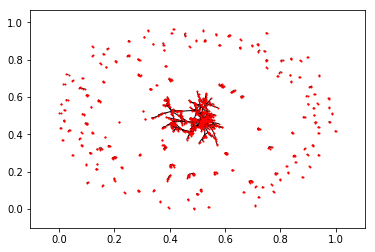

In [22]:
# show graph of connections
def get_graph_of_connections(patterns, card=2):
    #G = nx.Graph(np.unique([e for p in patterns for s in p for e in s.objects()]))
    G = nx.Graph()
    if card == 2:
        for c in patterns[0]:
            G.add_edge(c.objects()[0], c.objects()[-1], weight=len(c.timestamps()))
    else:
        raise NotImplementedError()
    return G

G = get_graph_of_connections(patterns)
nx.draw_networkx(G, with_labels=False, node_size=1)
plt.savefig("connections_graph.png", dpi=1000)
nx.write_graphml(G,'connections_graph.xml')

In [23]:
clusterer = Clusterer(dist_matrix, linkage='complete')

cl_labels = clusterer.cluster(verbose=1)

NameError: name 'dist_matrix' is not defined